In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [4]:
#Setting up functions to calculate Sa (helical order parameter) and Rg (radius of gyration)
# will be using data from the trajectories (which are loaded in further below) 

# using a loop that can iterate over every residue from defined start/stop residues 
# we're comparing the residues between i and i+6 to get a structural understanding over the sequence
# this is based on CA, which provides info about relationships of dihedral angles between residues and how that relates to helical stability 
# ending the loop with finding Sa and making an array of values we can plot later 
def calc_SA(trj,helix,start,stop):
 RMS_start=start
 RMS_stop=stop
 RMS=[]
 for i in range(RMS_start,RMS_stop):
    sel=helix.topology.select("residue %s to %s and name CA" % (i,i+6))
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
 RMS=np.asarray(RMS)
 Sa_sum=np.zeros((trj.n_frames))
 Sa=(1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
 return Sa


# calculating the radius of gyration using the mass info stored in the topology
# iterating over the CA values, we can calculate the Rg and plot these values along w Sa values 
# these two metrics will give us info about the overall unfolding/folding and helicity/non-helical collapsed states in a sequence! 
def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

In [5]:
# defining a few more functinons 

#free energy function takes inputs of all the values that go into computing a free energy
# Creates a histogram of 30 bins across the two dimensions (in this case, Rg and Sa) 
# we will basically use this function to get an understanding of the Rg vs Sa comparison by number of frames
def free_energy(a,b,T,y0,ymax,x0,xmax):
  free_energy,xedges,yedges=np.histogram2d(a,b,30,[[y0,ymax],[x0,xmax]],normed=True,weights=None)
  free_energy=np.log(np.flipud(free_energy)+.000001)
  free_energy=-(0.001987*T)*free_energy
  return free_energy,xedges,yedges


# the same function WITH an added parameter of weights! 
# once we reweight using all of the data, we can add this in to see which frames/states end up being slightly more important 
def free_energy_reweight(a, b, T, y0, ymax, x0, xmax,weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

In [6]:
# defining a function to look at the RMSD of the dihedrals 
# calculates the cosine differences (gives us a sort of normalized difference metric, since cos ranges from 0 to 1) 
# this will be used to determine the rmsd values between the experimental/predicted structures 

def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd

In [7]:
# making a dssp!! 
# exact same idea as the ones we looked at in class
# this will provide necessary info on helical content over frames (since that's what we care about with Tau-5) 

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1
 dsspH[dsspH=='E']=0
 dsspH[dsspH=='C']=0
 dsspH[dsspH=='NA']=0
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1)
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspH[:,i].astype(float)
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5]

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1)
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E

In [8]:
# Making an array of phi psi angles along the trajectory
# In class we made a dictionary with chi angles as well, this is just making a function to store the phi/psi angles since that's all we are interested in for this case 
# we're also storing these values with the labels they correspond to for easier indexing/plotting when needed

def calc_phipsi(trj):
 indices_phi, phis = md.compute_phi(trj)
 indices_psi, psis = md.compute_psi(trj)
 phi_label=[]
 for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
      phi_label.append(resindex)
 phi_label=np.array(phi_label)
 #print(phi_label)
 psi_label=[]
 for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
      psi_label.append(resindex)
 psi_label=np.array(psi_label)
 #print(psi_label)
 phipsi=[]
 for i in range(0,len(phi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
 phipsi_array=np.array(phipsi)
 return(phipsi_array,psi_label,phi_label)

In [9]:
# statistical error analysis! can be used to estimate variance of a dataset, especially for Monte Carlo simulations 
# and since SESCA uses Bayesian predictions w Monte Carlo simulations, this should be perfect 
# works by reducing autocorrelation by averaging the data until it's minimized 

# defines blocks, loops over them 
# then, finds the sum of normalized autocorrelations (M) weighted on block size 
# compares the M values with a defined criticcal value
# if the comparison shows that the acf is small enough, then we're good to go!! 
# if not, we get a message saying we should use more data to get more accurate predictions
def block(x):
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    for i in arange(0,d):
        n = len(x)
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        s[i] = var(x)
        x = 0.5*(x[0::2] + x[1::2])

    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

**Now that we've defined necessary functions, we can import the files we need and set up a trajectory exactly as we did in class**

In [10]:
# Importing all of the files needed to analyze this 

pdb = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/prot.drug.pdb'
trajectory = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/mutant_strided.dcd'
helixpdb = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/R2_R3_AA_allhelix.pdb'
outdir = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/reweight_trial/ensembles/'
weight_file = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/reweight_trial/weights/combined_data/CA-C-CD/weights_final.dat'
weights=np.loadtxt(weight_file)

if not os.path.exists(outdir):
    os.makedirs(outdir)


print("outdir",outdir)
print("pdb",pdb)
print("helixpdb",helixpdb)
print("trajectory",trajectory)
print("weights_file",weight_file)

outdir /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/reweight_trial/ensembles/
pdb /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/prot.drug.pdb
helixpdb /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/R2_R3_AA_allhelix.pdb
trajectory /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/mutant_strided.dcd
weights_file /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/reweight_trial/weights/combined_data/CA-C-CD/weights_final.dat


In [11]:
# trajectory load and info! 

trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
selection = trj.top.select("resid 1 to 56")
trj = trj.atom_slice(selection)
trj = trj[1:]
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [12]:
# specific residue info! 

nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

In [13]:
# printing out all the numbers/sequences we might need for analysis

print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 702

Number of residues: 56

Number of protein residues: 56

Number of frames: 3211

Starting frame: 0

Last frame: 3211

sequence:  [LEU1, ASP2, TYR3, GLY4, SER5, ALA6, ALA7, ALA8, ALA9, ALA10, ALA11, ALA12, GLN13, CYS14, ARG15, TYR16, GLY17, ASP18, LEU19, ALA20, SER21, LEU22, HIS23, GLY24, ALA25, GLY26, ALA27, ALA28, GLY29, PRO30, GLY31, SER32, GLY33, SER34, PRO35, SER36, ALA37, ALA38, ALA39, SER40, SER41, SER42, ALA43, HIS44, THR45, LEU46, PHE47, THR48, ALA49, GLU50, GLU51, GLY52, GLN53, LEU54, TYR55, GLY56]

residue names:  ['LEU', 'ASP', 'TYR', 'GLY', 'SER', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'GLN', 'CYS', 'ARG', 'TYR', 'GLY', 'ASP', 'LEU', 'ALA', 'SER', 'LEU', 'HIS', 'GLY', 'ALA', 'GLY', 'ALA', 'ALA', 'GLY', 'PRO', 'GLY', 'SER', 'GLY', 'SER', 'PRO', 'SER', 'ALA', 'ALA', 'ALA', 'SER', 'SER', 'SER', 'ALA', 'HIS', 'THR', 'LEU', 'PHE', 'THR', 'ALA', 'GLU', 'GLU', 'GLY', 'GLN', 'LEU', 'TYR', 'GLY']

residue index:  [0, 1, 2, 3, 4, 5, 6

In [14]:
# can use the offset to align the experimental and simulation data 

residue_offset=390
prot_res_renum=np.asarray(prot_res)+residue_offset
residue_number = range(0,residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

Residue Number Range: range(0, 56)


In [15]:
# computing DSSP values to get helical content 

dssp=md.compute_dssp(trj, simplified=True)
np.savetxt(outdir+"/dssp.out",dssp,fmt='%s')
H1_H,H1_E=dssp_convert(dssp)

In [16]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1
dsspH[dsspH=='E']=0
dsspH[dsspH=='C']=0
dsspH[dsspH=='NA']=0
dsspH=dsspH.astype(int)
np.savetxt(outdir+"/dssp.H.dat",dsspH,fmt='%i')
np.savetxt(outdir+"/Hprop.dat",np.column_stack((prot_res_renum,H1_H)),fmt="%.3f")

In [17]:
dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
np.savetxt(outdir+"/dssp.E.dat",dsspE,fmt='%i')
np.savetxt(outdir+"/Eprop.dat",np.column_stack((prot_res_renum,H1_E)),fmt="%.3f")

In [18]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

In [19]:
# also copmuting the dssp in the cse of reweighting!! 
# we want to compare how the experimental data can change the predictions of secondary structure propensities 

Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)

reweight_Hprop=[]
reweight_Eprop=[]
for i in range(0,len(Hprop)):
    reweight_Hprop.append(np.dot(dsspH[:,i],weights))
    reweight_Eprop.append(np.dot(dsspE[:,i],weights))

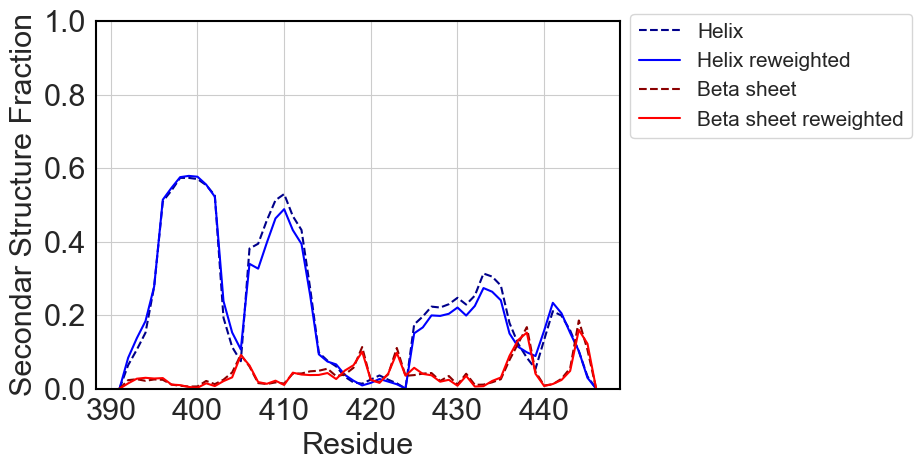

In [20]:
# and now that we have the helical vs beta sheet structure for BOTH the initial predictions and the reweighting, we can see how that changes across residue sequences
# the "SS Fraction" is basically looking at how many frames at that residue have that structure compared to the entire trajectory

plt.clf()
plt.plot(prot_res_renum,Hprop,color='darkblue', label='Helix',linestyle='dashed')
plt.ylim(0,1.0)
plt.plot(prot_res_renum,reweight_Hprop,color='blue', label='Helix reweighted')
plt.plot(prot_res_renum,Eprop,color='darkred', label='Beta sheet',linestyle='dashed')
plt.plot(prot_res_renum,reweight_Eprop,color='red', label='Beta sheet reweighted')
plt.xlabel('Residue', size=22)
plt.ylabel('Secondar Structure Fraction', size=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.85), fontsize=15)
plt.savefig('%s/SS.reweight.pdf'%outdir, bbox_inches='tight')

In [21]:
# Now, we're going to do a similar process but for Rg and Sa values rather than SS propensities
# First, we need to calculate the necessary Rg values for the trajectory and save that information 
# we can also calculate the mean + or - the standard error for an overall estimate of Rg across the ensemble 

rg=calc_Rg(trj)
np.savetxt(outdir+"/Rg.dat",rg,fmt="%.3f")
print("CA Radius of Gyration All:%6.3lf"%np.average(rg),"+_%6.3lf"%block(rg)**.5)
np.savetxt(outdir+"/Rg.ave.dat",np.column_stack((np.average(rg),block(rg)**.5)),fmt="%.3f")

CA Radius of Gyration All: 1.512 +_ 0.029


In [22]:
#looking at probability mass function! Using the Rg values from the cell before, we can figure out what the unbiased vs reweighted data suggest about the Rg of the ensemble
# making a histogram across possible Rg values and plotting the probability for both unbiased/reweighted 
# once we've computed and stored the Rg vs probability values, we can go to the next cell to actually make the plot

def pmf1d(x,nbins,range=None, weights = None, return_bin_centers = True):
    count,edge = np.histogram(x,bins = nbins,range=range,weights = weights)
    if weights is None:
        p = count/len(x)
    else:
        p = count
    if return_bin_centers:
        return p,edge[:-1]+np.diff(edge)/2
    else:
        return p  
    

p1, bc1 = pmf1d(rg, nbins=50)
p2, bc2 = pmf1d(rg, nbins=50, weights=weights)

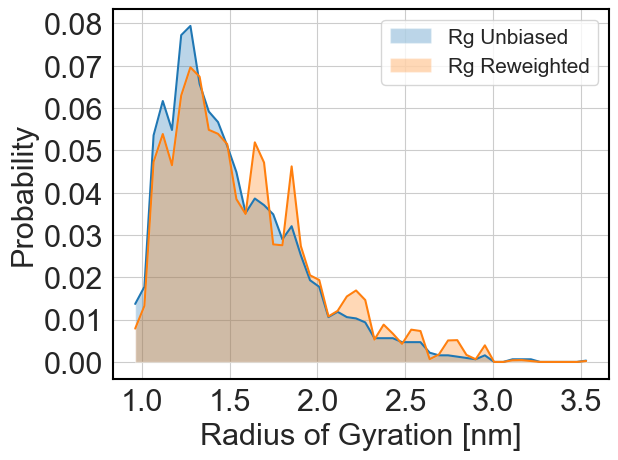

In [23]:
plt.plot(bc1,p1)
plt.plot(bc2,p2)
plt.fill_between(bc1,p1, alpha=0.3, label='Rg Unbiased')
plt.fill_between(bc2, p2, alpha=0.3, label='Rg Reweighted')
plt.legend(loc='upper right', fontsize=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Radius of Gyration [nm]',  fontsize=22)
plt.ylabel('Probability', fontsize=22)
plt.savefig('%s/Rg.probability.pdf'%outdir, bbox_inches='tight')

In [24]:
# now we can analyze the backbone helical values specifically. Goal is to make the free energy plot of Rg vs Sa
# load in the trajectory 
helixBB = md.load_pdb(helixpdb)


trjBB = md.load(trajectory, top=pdb,stride=1)
trjBB = trjBB[1:]
BB=trjBB.topology.select("name CA")
HBB = helixBB.topology.select("name CA")

# restricting to only the backbone atom we want (CA) 
trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)

trjBB.center_coordinates()
helixBB.center_coordinates()

# calculating the Sa for the backbone using the function defined earlier 
Sa= calc_SA(trjBB,helixBB,0, 49)

# can save information about the average (similar to what we did for Rg) 
Sa_total=np.sum(Sa, axis=0)
Sa_ave=np.average(Sa,axis=1)
np.savetxt(outdir+"/Sa.dat",Sa,fmt="%.3f")
np.savetxt(outdir+"/Sa.total.dat",Sa_total,fmt="%.3f")

In [25]:
# Function to make the Rg vs Sa free energy plot!! 
# uses the free energy function we defined earlier and then defines aesthetic choices too! 

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0

def plot_Rg_vs_Sa(a, b, T, y0, ymax, x0, xmax, scatter_x=None, scatter_y=None, weight=None, title="", filename="plot.png"):
    # Calculate free energy
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy) + 0.000001)
    free_energy = -(0.001987 * T) * free_energy

    # Create and customize the plot
    fig = plt.figure(figsize=(10, 8))
    plt.scatter(scatter_x, scatter_y, marker='.', c='white', s=800, edgecolors='black', alpha=0.8)
    im = plt.imshow(free_energy, interpolation='gaussian', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    cmap='jet', aspect='auto')
    plt.title(title, fontsize=25, fontweight='bold', pad=20)
    cbar_ticks = [0, 1, 2, 3]
    cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=15)
    cb.set_label("Free Energy (kcal/mol)", labelpad=35, fontsize=30, rotation=270)
    imaxes = plt.gca()
    plt.ylabel("Radius of Gyration [nm]", size=35, labelpad=15, fontweight='bold')
    plt.xlabel(r"S$\alpha$", size=35, labelpad=15, fontweight='bold')
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.axes(cb.ax)
    plt.clim(vmin=0.1, vmax=3.0)
    #plt.yticks(size='26')
    cb.ax.tick_params(labelsize=30)
    
    #create the path
    file_path = os.path.join(outdir, filename)
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

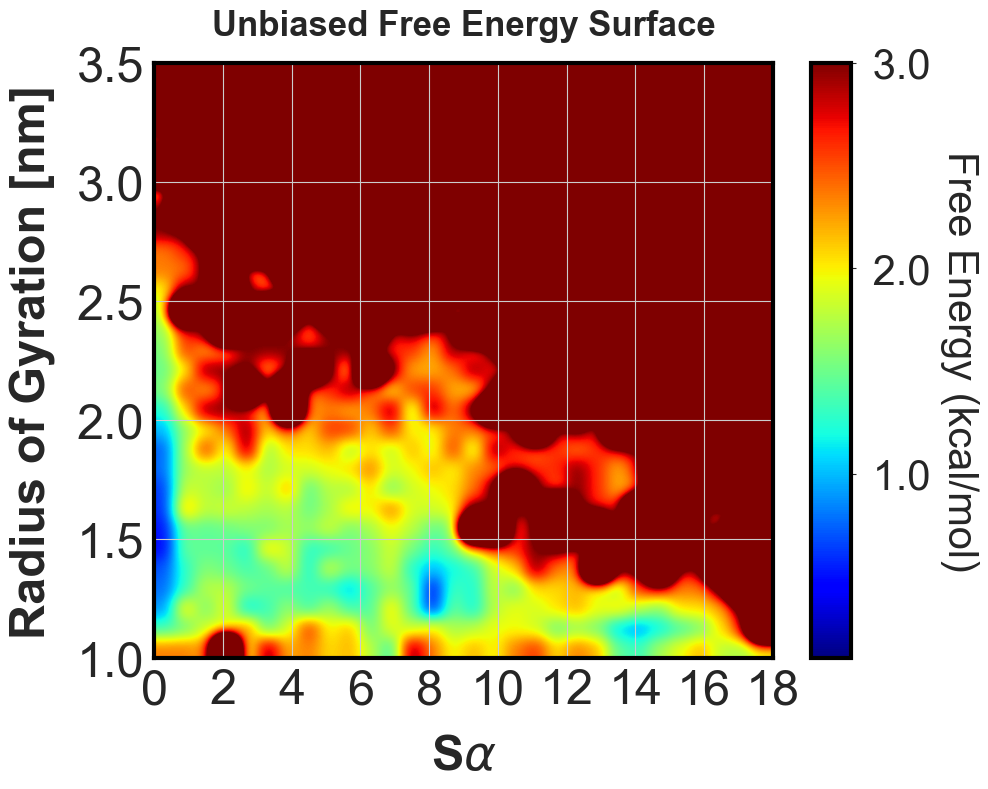

In [26]:
# plotting for unbiased! 
plot_Rg_vs_Sa(rg, Sa_total, 300, 1.0, 3.5, 0, 18.0, weight=None, title='Unbiased Free Energy Surface', filename='unbiased.rg_vs_sa.png')

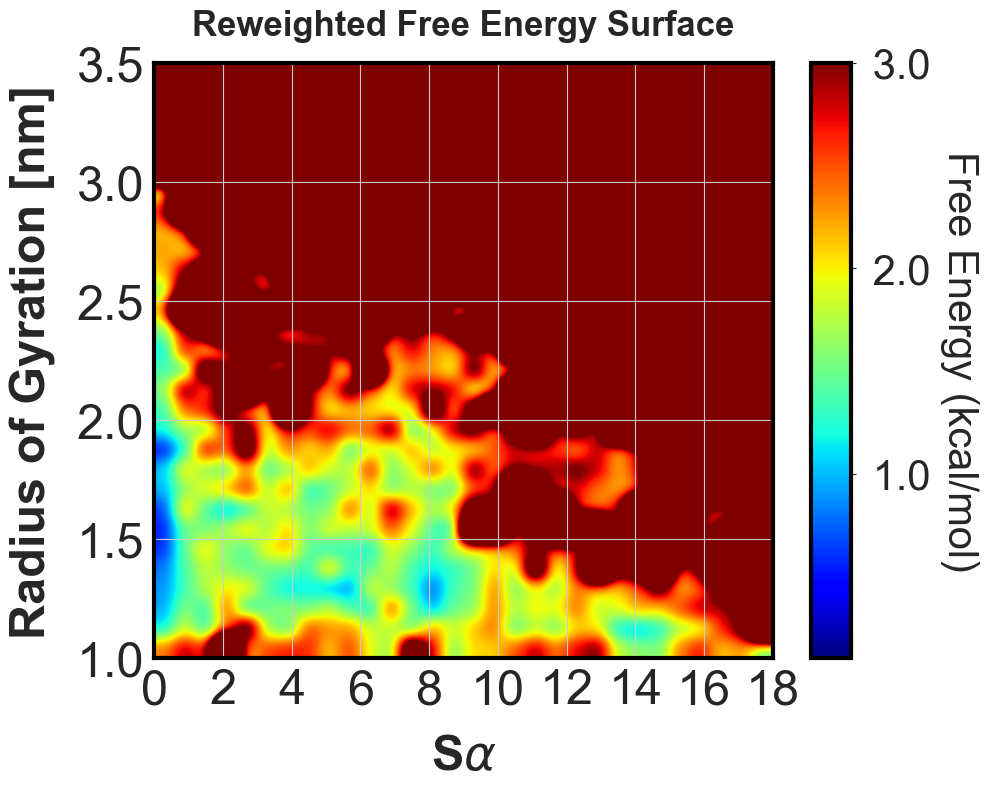

In [27]:
# plotting for reweighted! 
plot_Rg_vs_Sa(rg, Sa_total, 300, 1.0, 3.5, 0, 18.0, weight=weights, title='Reweighted Free Energy Surface', filename='reweight.rg_vs_sa.png')

In [28]:
#yay contact maps!! Using code like what we did in class to plot the contacts across a stretch of interesting residues
# since we're looking at Tau-5, the "interesting residues" of choice are those in R2 and R3, where increased helicity should show interactions

contact_maps = []
distance_maps= []

contact_maps_reweight = []
distance_maps_reweight = []

for i in range(0,len(nres)):
    contact_map = []
    distance_map = []

    contact_map_reweight = []
    distance_map_reweight = []
    for j in range(0,len(nres)):
        if i == j:
            contacts = 0
            contacts_reweight = 0
            distance = 0
            distance_reweight =0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            distance_reweight= np.dot(array[:,0],weights)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
            contacts_reweight = np.dot(contact[:,0],weights)
        distance_map.append(distance)
        distance_map_reweight.append(distance_reweight)
        contact_map.append(contacts)
        contact_map_reweight.append(contacts_reweight)
    contact_maps.append(contact_map)
    contact_maps_reweight.append(contact_map_reweight)
    distance_maps.append(distance_map)
    distance_maps_reweight.append(distance_map_reweight)

final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(distance_maps).astype(float)

final_map_reweight = np.asarray(contact_maps_reweight).astype(float)
final_distance_reweight = np.asarray(distance_maps_reweight).astype(float)

In [29]:
# this is looping through the helix and fixing the numbering of residues to match what theresidue numbers we're used to 

sequence = []
for i, residue in enumerate(trj.topology.residues, start=1):
    sequence.append(f"{residue.name}{i + 390}")

In [30]:
# excluding the first element because that is probably not an accurate estimate of the simulation 

n=6
for i in range (0,len(sequence)):
  if (i % n !=0):
   sequence[i]=''

print(sequence)

['LEU391', '', '', '', '', '', 'ALA397', '', '', '', '', '', 'GLN403', '', '', '', '', '', 'LEU409', '', '', '', '', '', 'ALA415', '', '', '', '', '', 'GLY421', '', '', '', '', '', 'ALA427', '', '', '', '', '', 'ALA433', '', '', '', '', '', 'ALA439', '', '', '', '', '', 'TYR445', '']


In [31]:
# defining our contact map function 

def plot_cmaps(map_data, residues, title=" ", filename = " " ):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    im = sns.heatmap(map_data, cmap = 'jet', ax = ax)
    ax.grid(which='both', alpha=0.5)


    plt.xticks(range(0,residues), sequence[0:residues], rotation=45, size=22)
    plt.yticks(range(0,residues),sequence[0:residues], rotation=45, size=22)

    cbar = im.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('Residue contact probability', labelpad=35, fontsize=30, rotation= 270)
    ax.set_title(title, size=30, pad=20, fontweight='bold' )
    ax.invert_yaxis()
    plt.tight_layout()
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
    for _, spine in cbar.ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
    
    filepath= os.path.join(outdir, filename)
    plt.savefig(filepath)

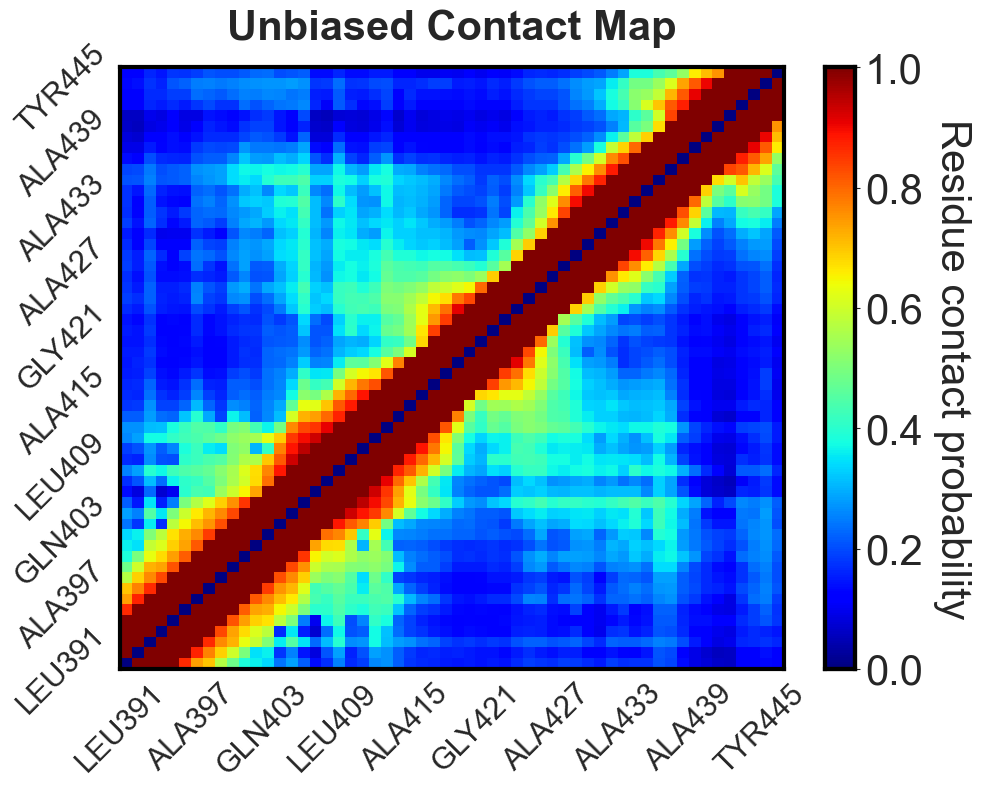

In [32]:
# plotting for unbiased! 

plot_cmaps(final_map, residues, title='Unbiased Contact Map', filename= "Unbiased_cmap.png")

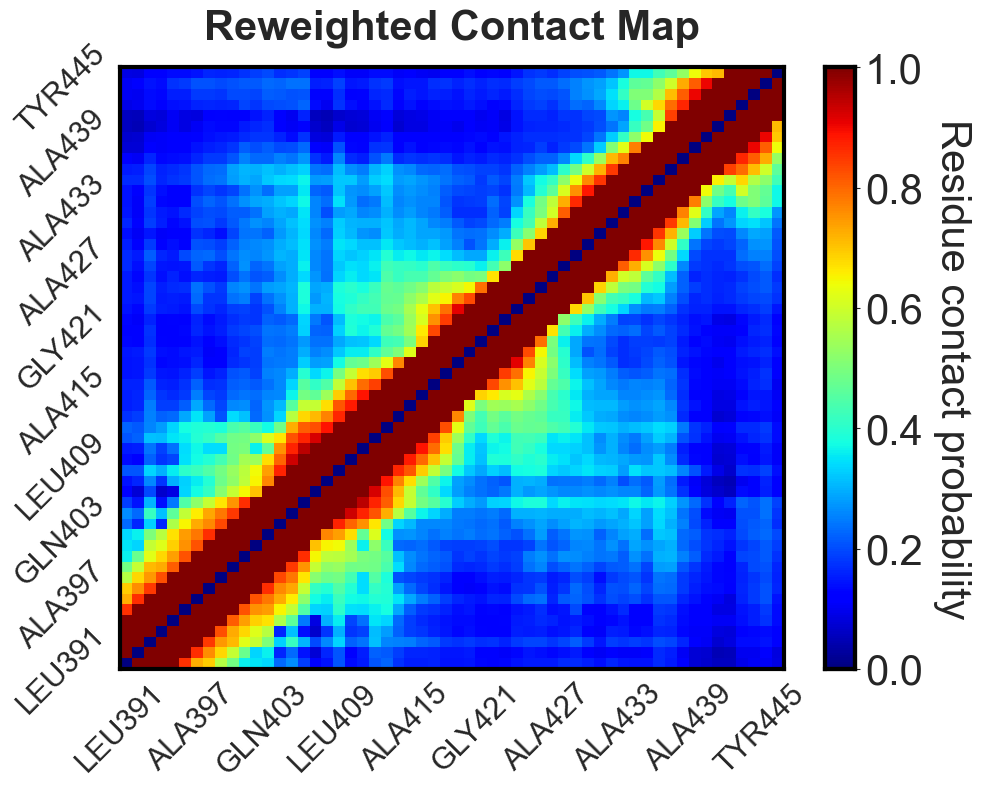

In [33]:
# and plotting for the reweighted map 

plot_cmaps(final_map_reweight, residues, title= 'Reweighted Contact Map', filename='Reweighted_cmap.pdf')